In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="poster", style="ticks")
plt.style.use("style.mplstyle")

In [2]:
from dataloader import *
kaepora = import_kaepora()

df = pd.read_csv("cross_match.csv", index_col="SN")
df.columns = df.columns.str.lower()
df.index = df.index.str.lower()
df.head()

kaepora = kaepora.join(df)
kaepora = kaepora.drop(columns=["v", "verr"])
del df

kaepora = kaepora[["v_siII", "v_siII_err", "z", "host name", "z_glade", "b", "b_err", "b_abs", "dist", "dist_err"]]
display(kaepora.info())
kaepora.head()

<class 'pandas.core.frame.DataFrame'>
Index: 311 entries, 2006td to 1992bo
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   v_siII      311 non-null    float64
 1   v_siII_err  302 non-null    float64
 2   z           291 non-null    float64
 3   host name   303 non-null    object 
 4   z_glade     189 non-null    float64
 5   b           189 non-null    float64
 6   b_err       87 non-null     float64
 7   b_abs       187 non-null    float64
 8   dist        189 non-null    float64
 9   dist_err    0 non-null      float64
dtypes: float64(9), object(1)
memory usage: 36.7+ KB


None

,v_siII,v_siII_err,z,host name,z_glade,b,b_err,b_abs,dist,dist_err
kaepora,,,,,,,,,,
2006td,10812.60,300.000,0.015880,ANON.,NaN,NaN,NaN,NaN,NaN,NaN
1996z,12142.10,233.568,0.007575,NGC2935,0.005758,10.690,0.3,-21.4257,26.493778,NaN
1996x,11173.10,222.453,0.006945,NGC5061,0.005628,11.100,0.3,-20.4397,20.320754,NaN
1996c,10689.10,222.453,0.027000,MCG+08-25-47,NaN,NaN,NaN,NaN,NaN,NaN
2005m,8093.94,231.052,0.022000,NGC2930,0.028281,14.459,NaN,-21.0518,126.521412,NaN


In [3]:
kaepora[(~kaepora['b'].isna()) & (kaepora['b_abs'].isna())]

,v_siII,v_siII_err,z,host name,z_glade,b,b_err,b_abs,dist,dist_err
kaepora,,,,,,,,,,
2012cg,11000.0,NaN,0.001460,NGC4424,0.001342,12.02,0.3,NaN,5.754073,NaN
1986g,10479.8,222.453,0.001825,NGC5128,0.000879,7.48,0.3,NaN,3.767434,NaN


## Redshift Bias Analysis

We first remove all SN without redshift reported

In [5]:
data = kaepora
data = data[~data['z'].isna()]
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 291 entries, 2006td to 2007f
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   v_siII      291 non-null    float64
 1   v_siII_err  282 non-null    float64
 2   z           291 non-null    float64
 3   host name   283 non-null    object 
 4   z_glade     185 non-null    float64
 5   b           185 non-null    float64
 6   b_err       86 non-null     float64
 7   b_abs       183 non-null    float64
 8   dist        185 non-null    float64
 9   dist_err    0 non-null      float64
dtypes: float64(9), object(1)
memory usage: 25.0+ KB


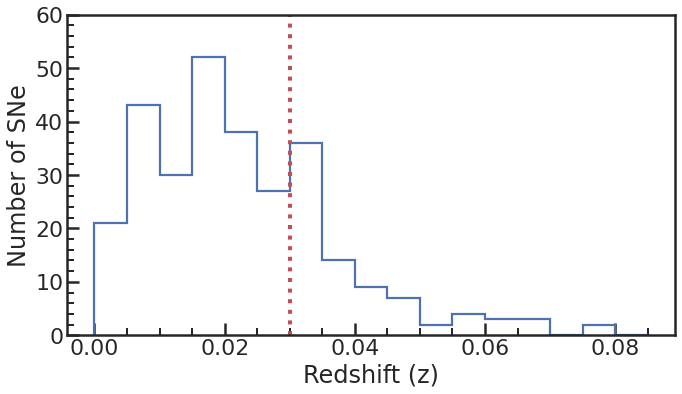

In [6]:
z_cutoff = 0.03

bins = np.arange(0, 9, 0.5) / 100
plt.hist(data['z'], bins=bins, histtype='step')
plt.vlines(z_cutoff, 0, 60, color='r', linestyle='dotted', linewidth=4)

plt.ylim(0, 60)
plt.xlabel('Redshift (z)')
plt.ylabel('Number of SNe')

plt.tight_layout()
plt.savefig('results/z_histogram.pdf')

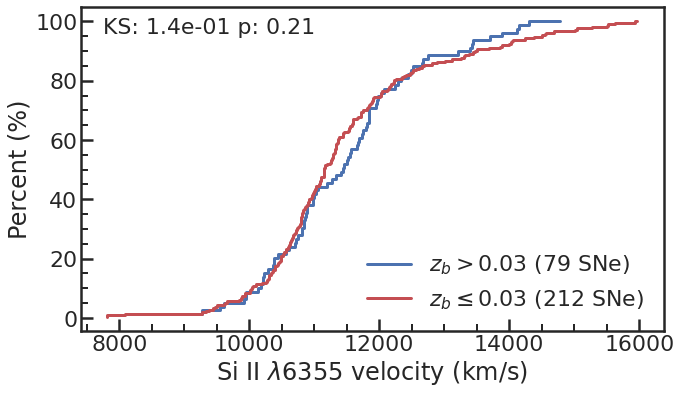

In [7]:
from scipy import stats
z_cutoff = 0.03
ks = stats.ks_2samp(data['v_siII'][data['z'] > z_cutoff], data['v_siII'][data['z'] <= z_cutoff])
bins = np.arange(7000, 16001, 500)

x = data['v_siII'][data['z'] > z_cutoff]
plt.plot(np.sort(x), np.arange(1, len(x) + 1) / len(x) * 100, linewidth=3, drawstyle='steps', label=f'$z_b > {z_cutoff:.2g}$ ({len(x)} SNe)')

x = data['v_siII'][data['z'] <= z_cutoff]
plt.plot(np.sort(x), np.arange(1, len(x) + 1) / len(x) * 100, linewidth=3, color='r', drawstyle='steps', label=f'$z_b \leq {z_cutoff:.2g}$ ({len(x)} SNe)')

plt.xlabel('Si II $\lambda$6355 velocity (km/s)')
plt.ylabel("Percent (%)")
plt.title(f'KS: {ks[0]:.1e} p: {ks[1]:.2f}', x=0.22, y=0.9, fontsize=22)
plt.legend(loc='lower right', fontsize=22, frameon=False)

plt.tight_layout()
plt.savefig('results/z_03_ks_test.pdf')

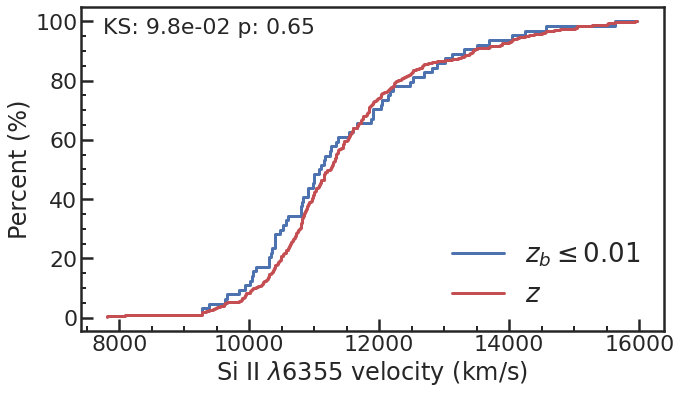

In [6]:
z_cutoff = 0.01
ks = stats.ks_2samp(data['v_siII'][data['z'] <= z_cutoff], data['v_siII'])
                                                                         
x = data['v_siII'][data['z'] <= z_cutoff]
plt.plot(np.sort(x), np.arange(1, len(x) + 1) / len(x) * 100, linewidth=3, drawstyle='steps', label=f'$z_b \\leq {z_cutoff:.2g}$')

x = data['v_siII']
plt.plot(np.sort(x), np.arange(1, len(x) + 1) / len(x) * 100, linewidth=3, color='r', drawstyle='steps', label=f'$z$')

plt.xlabel('Si II $\lambda$6355 velocity (km/s)')
plt.ylabel("Percent (%)")
plt.title(f'KS: {ks[0]:.1e} p: {ks[1]:.2f}', x=0.22, y=0.9, fontsize=22)
plt.legend(loc='lower right', fontsize=26, frameon=False)

plt.tight_layout()


Text(0, 0.5, 'Number of SNe')

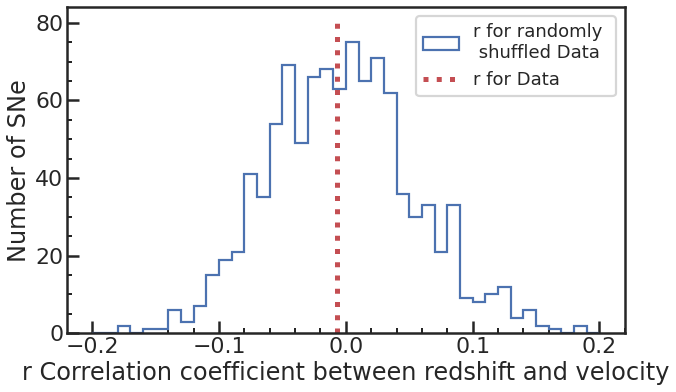

In [7]:
def get_correlation(data, column_a, column_b):
    return data.corr().loc[column_a, column_b]
    

def simulate(data, rep=1000):
    
    def make_sample(size=1000):
        shuffle_idx = np.random.randint(0, len(data), size=len(data))
        sample = pd.DataFrame.copy(data)
        sample['z'] = sample['z'].values[shuffle_idx]
        return sample
    
    results = []
    for i in range(rep):
        sample = make_sample()
        statistics = get_correlation(sample, 'v_siII', 'z')
        results.append(statistics)
        
    return results

results = simulate(data[['v_siII', 'z']])
plt.hist(results, bins=np.arange(-.20, .20+.01, .01), histtype='step', label='r for randomly \n shuffled Data');
plt.vlines(get_correlation(data, 'v_siII', 'z'), 0, 80, color='r', linestyle='dotted', label='r for Data')
plt.xlabel('r Correlation coefficient between redshift and velocity')
plt.legend()
plt.ylabel('Number of SNe')

In [8]:
np.sum(np.abs(get_correlation(data, 'v_siII', 'z')) <= np.abs(results)) / len(results)

0.913

In [9]:
z_cutoffs = [0.01, 0.02, 0.03, 0.04]
bins = np.arange(7000, 16001, 500)

results = []
for z_cutoff in z_cutoffs:
    sample_greater = data['v_siII']
    sample_lesser = data['v_siII'][data['z'] <= z_cutoff]
    n = len(sample_greater)
    m = len(sample_lesser)
    alpha = 0.05
    D_level = 1/np.sqrt(n) * np.sqrt(-np.log(alpha/2) * (1 + n/m)/2)
    
    ks_test = stats.ks_2samp(sample_greater, sample_lesser)
    results.append({
        '$z_b$': z_cutoff,
        'ks': ks_test[0],
        'pvalue': ks_test[1],
#         'size ($>z_b$)': len(sample_greater),
        'size ($\le z_b$)': len(sample_lesser),
        'D_level': D_level,
        'ks > D_level': ks_test[0] > D_level
    })
    
pd.DataFrame(results)

,$z_b$,ks,pvalue,size ($\le z_b$),D_level,ks > D_level
0,0.01,0.097884,0.654350,64,0.187504,False
1,0.02,0.076162,0.589153,147,0.137424,False
2,0.03,0.037169,0.992625,212,0.122631,False
3,0.04,0.013351,1.000000,261,0.115780,False


Text(0.5, 62.499999999999915, 'Redshift (z)')

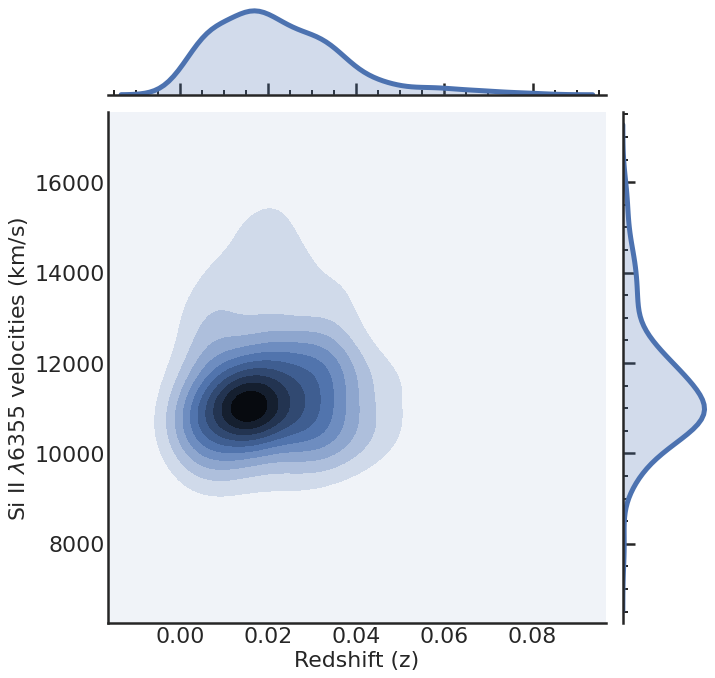

In [25]:
def standardize(x):
    return x
    return (x - np.mean(x)) / np.std(x)

p = sns.jointplot(standardize(data['z']), standardize(data['v_siII']), kind='kde', height=10)

# JointGrid has a convenience function
p.set_axis_labels('x', 'y', fontsize=16)

# or set labels via the axes objects
p.ax_joint.set_ylabel('Si II $\lambda$u6355 velocity (km/s)', fontsize=22)
p.ax_joint.set_xlabel('Redshift (z)', fontsize=22)

Text(0, 0.5, 'count')

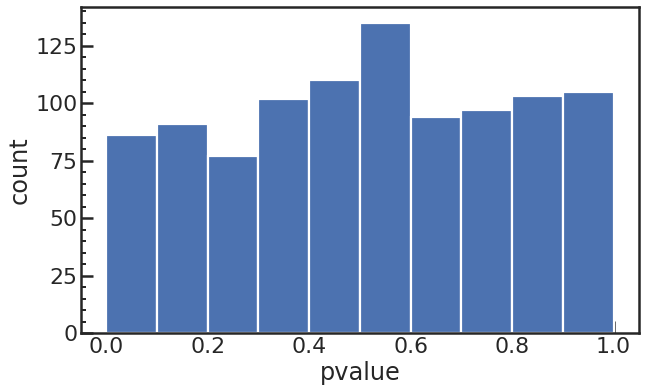

In [97]:
from scipy.stats import norm
cutoffs = np.arange(-2, 2+0.5, 1)
name = list(range(len(cutoffs)))

cutoffs = np.append(cutoffs, sample['z'].median())
name.append('median')

# p = sns.jointplot(standardize(sample['z']), standardize(sample['v']), kind='kde', height=6)

# # JointGrid has a convenience function
# p.set_axis_labels('x', 'y', fontsize=16)

# # or set labels via the axes objects
# p.ax_joint.set_ylabel('v', fontsize=22)
# p.ax_joint.set_xlabel('z', fontsize=22)

def simulate(size=300):
    sample = pd.DataFrame(
        [norm.rvs(size=size), norm.rvs(10000, 1000, size=size)],
        index=['z', 'v']
    ).T
    cutoff = np.median(sample['z'])
    sample_greater, sample_lesser = sample['v'][sample['z'] <= cutoff], sample['v'][sample['z'] > cutoff]
    ks_test = stats.ks_2samp(sample_greater, sample_lesser)
    return ks_test[1]


    
results = []
for i in range(1000):
    results.append(simulate(size=3000))
    
plt.hist(results)
plt.xlabel('pvalue')
plt.ylabel('count')

## Host Apparent Magnitude Bias Analysis

We first remove all SN without host B-band magnitude reported

In [3]:
data = kaepora[~kaepora["b"].isna()]
display(data.info())
display(data.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 189 entries, 1996z to 2007f
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   v_siII      189 non-null    float64
 1   v_siII_err  182 non-null    float64
 2   z           185 non-null    float64
 3   host name   189 non-null    object 
 4   z_glade     189 non-null    float64
 5   b           189 non-null    float64
 6   b_err       87 non-null     float64
 7   b_abs       187 non-null    float64
 8   dist        189 non-null    float64
 9   dist_err    0 non-null      float64
dtypes: float64(9), object(1)
memory usage: 16.2+ KB


None

,v_siII,v_siII_err,z,z_glade,b,b_err,b_abs,dist,dist_err
count,189.000000,182.000000,185.000000,189.000000,189.000000,87.000000,187.000000,189.000000,0.0
mean,11548.345238,248.277753,0.017812,0.017609,13.222529,0.323793,-20.756398,78.510114,NaN
std,1388.452042,43.068626,0.011120,0.011195,1.526256,0.183982,0.819760,49.303533,NaN
min,8093.940000,221.129000,0.000677,0.000879,7.480000,0.060000,-22.815600,3.767434,NaN
25%,10630.600000,222.453000,0.008770,0.007545,12.320000,0.295000,-21.301950,36.953310,NaN
50%,11237.300000,233.036500,0.016471,0.016404,13.518000,0.300000,-20.800600,72.535251,NaN
75%,12153.900000,253.142000,0.024233,0.024212,14.372000,0.330000,-20.338150,107.228197,NaN
max,15969.300000,550.514000,0.064387,0.064980,16.280000,1.720000,-18.208900,292.415000,NaN


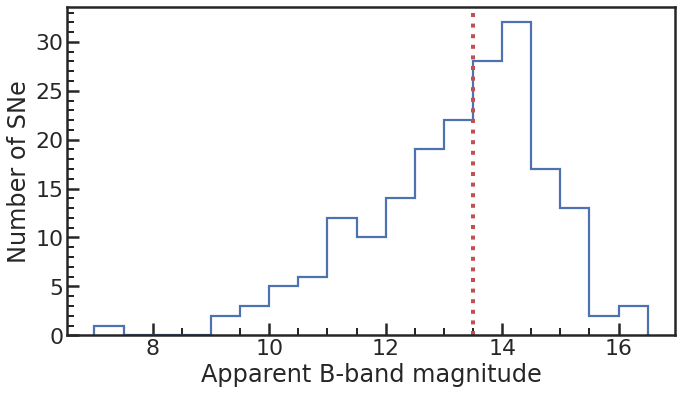

In [4]:
b_cutoff = data['b'].median().round(1)

bins = np.arange(7, 17, 0.5)
plt.hist(data['b'], bins=bins, histtype='step')
plt.axvline(b_cutoff, c='r', linestyle='dotted', linewidth=4, label="$M_\mathrm{B, median}$"+f"$={b_cutoff}$")

plt.xlabel('Apparent B-band magnitude')
plt.ylabel('Number of SNe')

plt.tight_layout()
plt.savefig('results/b_histogram.pdf')

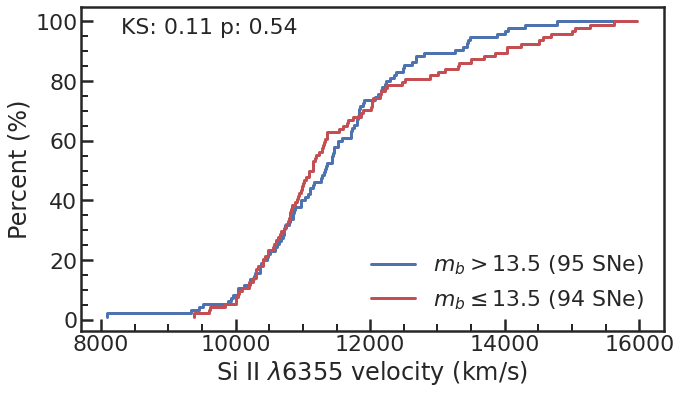

In [5]:
from scipy import stats
b_cutoff = 13.5
ks = stats.ks_2samp(data['v_siII'][data['b'] > b_cutoff], data['v_siII'][data['b'] <= b_cutoff])
bins = np.arange(7000, 16001, 500)

x = data['v_siII'][data['b'] > b_cutoff]
plt.plot(np.sort(x), np.arange(1, len(x) + 1) / len(x) * 100, linewidth=3, drawstyle='steps', label=f'$m_b > {b_cutoff:.5g}$ ({len(x)} SNe)')

x = data['v_siII'][data['b'] <= b_cutoff]
plt.plot(np.sort(x), np.arange(1, len(x) + 1) / len(x) * 100, linewidth=3, color='r', drawstyle='steps', label=f'$m_b \leq {b_cutoff:.5g}$ ({len(x)} SNe)')

plt.xlabel('Si II $\lambda$6355 velocity (km/s)')
plt.ylabel("Percent (%)")
plt.title(f'KS: {ks[0]:.2} p: {ks[1]:.2f}', x=0.22, y=0.9, fontsize=22)
plt.legend(loc='lower right', fontsize=22, frameon=False)

plt.tight_layout()
plt.savefig('results/b_ks_test.pdf')

In [6]:
b_cutoffs = np.arange(12, 15+1, 0.5)
bins = np.arange(7000, 16001, 500)

results = []
for b_cutoff in b_cutoffs:
    sample_greater = data['v_siII'][data['b'] > b_cutoff]
    sample_lesser = data['v_siII'][data['b'] <= b_cutoff]
    n = len(sample_greater)
    m = len(sample_lesser)
    alpha = 0.05
    D_level = 1/np.sqrt(n) * np.sqrt(-np.log(alpha/2) * (1 + n/m)/2)
    
    ks_test = stats.ks_2samp(sample_greater, sample_lesser)
    results.append({
        '$b_b$': b_cutoff,
        'ks': ks_test[0],
        'pvalue': ks_test[1],
        'size ($\le b_b$)': len(sample_lesser),
        'D_level': D_level,
        'ks > D_level': ks_test[0] > D_level
    })
    
pd.DataFrame(results)

,$b_b$,ks,pvalue,size ($\le b_b$),D_level,ks > D_level
0,12.0,0.083553,0.961065,41,0.239685,False
1,12.5,0.065483,0.991816,53,0.219915,False
2,13.0,0.126068,0.437622,72,0.203425,False
3,13.5,0.111758,0.540470,94,0.197577,False
4,14.0,0.120504,0.507520,122,0.206512,False
5,14.5,0.124668,0.725694,155,0.257192,False
6,15.0,0.210526,0.412823,171,0.336534,False
7,15.5,0.342391,0.516325,184,0.615558,False


## Host Absolute Magnitude Bias Analysis

We first remove all SN without host B-band absolute magnitude reported

In [7]:
data = kaepora[~kaepora["b_abs"].isna()]
display(data.info())
display(data.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 187 entries, 1996z to 2007f
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   v_siII      187 non-null    float64
 1   v_siII_err  181 non-null    float64
 2   z           183 non-null    float64
 3   host name   187 non-null    object 
 4   z_glade     187 non-null    float64
 5   b           187 non-null    float64
 6   b_err       85 non-null     float64
 7   b_abs       187 non-null    float64
 8   dist        187 non-null    float64
 9   dist_err    0 non-null      float64
dtypes: float64(9), object(1)
memory usage: 16.1+ KB


None

,v_siII,v_siII_err,z,z_glade,b,b_err,b_abs,dist,dist_err
count,187.000000,181.000000,183.000000,187.000000,187.000000,85.000000,187.000000,187.000000,0.0
mean,11556.991711,248.420431,0.017989,0.017785,13.259668,0.324353,-20.756398,79.298878,NaN
std,1393.089268,43.144942,0.011050,0.011123,1.472430,0.186122,0.819760,48.967916,NaN
min,8093.940000,221.129000,0.000677,0.000908,9.150000,0.060000,-22.815600,4.702285,NaN
25%,10634.400000,222.453000,0.009090,0.008105,12.342500,0.290000,-21.301950,38.062730,NaN
50%,11274.300000,233.198000,0.016739,0.016470,13.535000,0.300000,-20.800600,74.316184,NaN
75%,12156.450000,253.271000,0.024399,0.024386,14.386000,0.330000,-20.338150,107.495133,NaN
max,15969.300000,550.514000,0.064387,0.064980,16.280000,1.720000,-18.208900,292.415000,NaN


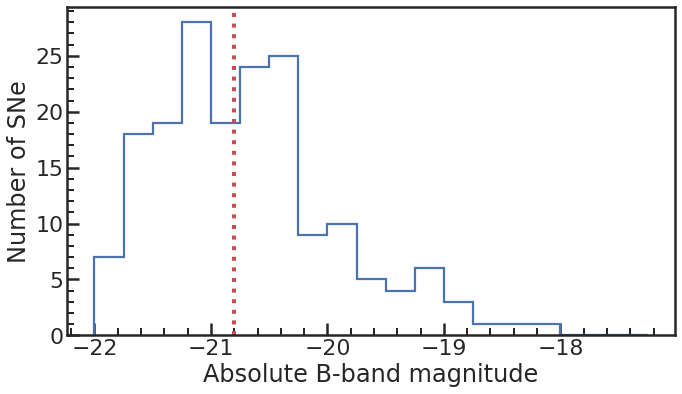

In [8]:
b_cutoff = data['b_abs'].median().round(1)

bins = np.arange(-22, -17, 0.25)
plt.hist(data['b_abs'], bins=bins, histtype='step')
plt.axvline(b_cutoff, c='r', linestyle='dotted', linewidth=4, label="$M_\mathrm{B, median}$"+f"$={b_cutoff}$")

plt.xlabel('Absolute B-band magnitude')
plt.ylabel('Number of SNe')

plt.tight_layout()
plt.savefig('results/b_abs_histogram.pdf')

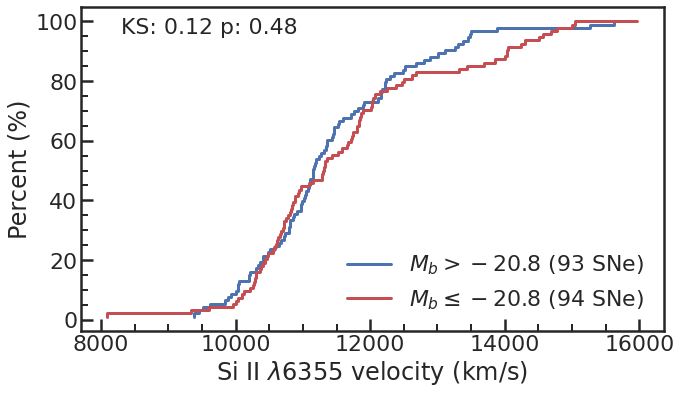

In [9]:
from scipy import stats
b_cutoff = -20.8
ks = stats.ks_2samp(data['v_siII'][data['b_abs'] > b_cutoff], data['v_siII'][data['b_abs'] <= b_cutoff])
bins = np.arange(7000, 16001, 500)

x = data['v_siII'][data['b_abs'] > b_cutoff]
plt.plot(np.sort(x), np.arange(1, len(x) + 1) / len(x) * 100, linewidth=3, drawstyle='steps', label=f'$M_b > {b_cutoff:.5g}$ ({len(x)} SNe)')

x = data['v_siII'][data['b_abs'] <= b_cutoff]
plt.plot(np.sort(x), np.arange(1, len(x) + 1) / len(x) * 100, linewidth=3, color='r', drawstyle='steps', label=f'$M_b \leq {b_cutoff:.5g}$ ({len(x)} SNe)')

plt.xlabel('Si II $\lambda$6355 velocity (km/s)')
plt.ylabel("Percent (%)")
plt.title(f'KS: {ks[0]:.2} p: {ks[1]:.2f}', x=0.22, y=0.9, fontsize=22)
plt.legend(loc='lower right', fontsize=22, frameon=False)

plt.tight_layout()
plt.savefig('results/b_abs_ks_test.pdf')

In [10]:
b_cutoffs = np.arange(-21, -20, 0.25)
bins = np.arange(7000, 16001, 500)

results = []
for b_cutoff in b_cutoffs:
    sample_greater = data['v_siII'][data['b_abs'] > b_cutoff]
    sample_lesser = data['v_siII'][data['b_abs'] <= b_cutoff]
    n = len(sample_greater)
    m = len(sample_lesser)
    alpha = 0.05
    D_level = 1/np.sqrt(n) * np.sqrt(-np.log(alpha/2) * (1 + n/m)/2)
    
    ks_test = stats.ks_2samp(sample_greater, sample_lesser)
    results.append({
        '$b_b$': b_cutoff,
        'ks': ks_test[0],
        'pvalue': ks_test[1],
        'size ($\le b_b$)': len(sample_lesser),
        'D_level': D_level,
        'ks > D_level': ks_test[0] > D_level
    })
    
pd.DataFrame(results)

,$b_b$,ks,pvalue,size ($\le b_b$),D_level,ks > D_level
0,-21.00,0.130919,0.372626,79,0.201061,False
1,-20.75,0.108117,0.593636,98,0.198859,False
2,-20.50,0.108575,0.647485,122,0.208553,False
3,-20.25,0.121088,0.693762,147,0.242195,False


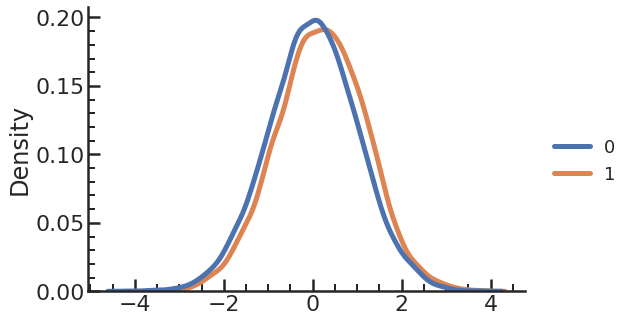

In [72]:
a = stats.norm(0, 1).rvs(size=10000)
b = stats.norm(0.2, 1).rvs(size=10000)

sns.displot([a, b], kind="kde", aspect=16/10)